<a href="https://colab.research.google.com/github/Deep-Learning-01/language-detection-using-cnn-pytroch/blob/main/language_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Required Libraries

In [ ]:
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
import zipfile
import pandas as pd
from sklearn import preprocessing

warnings.filterwarnings("ignore")

## Extract zip file

In [ ]:
raw_zip_path = 'drive/MyDrive/Language_ide.zip'
target_dir = 'final_data'
os.makedirs(target_dir)

with zipfile.ZipFile(raw_zip_path,"r") as zip_f:
    zip_f.extractall(target_dir)

#### Check the number of classes in the dataset

In [ ]:
audio_dir1 = os.path.join(target_dir,'Language_ide')
os.listdir(audio_dir1)

['Hindi', 'Gujarati', 'Tamil', 'Bengoli']

#### Check number of files in each class

In [ ]:
classes = []
for i in os.listdir(audio_dir1):
    classes.append(i)
    class_path = audio_dir1 + '/' + str(i)
    audio_clips = os.listdir(class_path)
    print(f"No. of .mp3 files in audio {i} folder = ",len(audio_clips))

No. of .mp3 files in audio Hindi folder =  500
No. of .mp3 files in audio Gujarati folder =  500
No. of .mp3 files in audio Tamil folder =  500
No. of .mp3 files in audio Bengoli folder =  500


In [ ]:
pip install pydub

##### Using pydub to convert mp3 to wav files for training in colab

In [ ]:
import os
from pydub import AudioSegment

os.makedirs("final_wav", exist_ok=True)

for folder in os.listdir(audio_dir1):
    class_path = os.path.join(audio_dir1, folder)
    for count, files in enumerate(os.listdir(class_path)):
        try:
            src = os.path.join(class_path, files)
            file_name = f"{folder}-{count}.wav"
            dst_folder = os.path.join("final_wav", folder)
            os.makedirs(dst_folder, exist_ok=True)
            dst = os.path.join(dst_folder, file_name)
            sound = AudioSegment.from_mp3(src)
            sound.export(dst, format="wav")
            print(f"Converted: {src} to {dst}")
        except Exception as e:
            print(f"Failed to convert {src}: {str(e)}")


Converted: final_data/Language_ide/Hindi/18.mp3 to final_wav/Hindi/Hindi-0.wav
Converted: final_data/Language_ide/Hindi/416.mp3 to final_wav/Hindi/Hindi-1.wav
Converted: final_data/Language_ide/Hindi/388.mp3 to final_wav/Hindi/Hindi-2.wav
Converted: final_data/Language_ide/Hindi/468.mp3 to final_wav/Hindi/Hindi-3.wav
Converted: final_data/Language_ide/Hindi/438.mp3 to final_wav/Hindi/Hindi-4.wav
Converted: final_data/Language_ide/Hindi/308.mp3 to final_wav/Hindi/Hindi-5.wav
Converted: final_data/Language_ide/Hindi/474.mp3 to final_wav/Hindi/Hindi-6.wav
Converted: final_data/Language_ide/Hindi/392.mp3 to final_wav/Hindi/Hindi-7.wav
Converted: final_data/Language_ide/Hindi/409.mp3 to final_wav/Hindi/Hindi-8.wav
Converted: final_data/Language_ide/Hindi/293.mp3 to final_wav/Hindi/Hindi-9.wav
Converted: final_data/Language_ide/Hindi/252.mp3 to final_wav/Hindi/Hindi-10.wav
Converted: final_data/Language_ide/Hindi/20.mp3 to final_wav/Hindi/Hindi-11.wav
Converted: final_data/Language_ide/Hindi

#### Rename the files in single format

In [ ]:
for folder in os.listdir(audio_dir1):
    class_path = audio_dir1 + '/' + str(folder)
    for count, files in enumerate(os.listdir(class_path)):
        try:
            dst = f"{folder}-{str(count)}.mp3"
            src =f"{audio_dir1}/{folder}/{files}"
            dst =f"{audio_dir1}/{folder}/{dst}"
            os.rename(src, dst)
        except FileExistsError:
             pass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Create Metadata for the dataset

In [ ]:
import pandas as pd
from sklearn import preprocessing

wav_dir = '/content/final_wav'
# Create metadata dictionary
metadata = {}
for label in os.listdir(wav_dir):
    class_path = wav_dir + '/' + str(label)
    audio_clips = os.listdir(class_path)
    for filename in audio_clips:
        metadata[filename] = label

# Create a metadata csv file
metadata = pd.DataFrame.from_dict(metadata, orient='index').reset_index().sort_values(by=0)
metadata.columns = ['filename', 'foldername']
le = preprocessing.LabelEncoder()
metadata['labels'] = le.fit_transform(metadata.foldername)
metadata.to_csv('metadata.csv', index=False)
metadata

,filename,foldername,labels
1998,Bengoli-341.wav,Bengoli,0
1656,Bengoli-297.wav,Bengoli,0
1657,Bengoli-361.wav,Bengoli,0
1658,Bengoli-279.wav,Bengoli,0
1659,Bengoli-153.wav,Bengoli,0
...,...,...,...
1337,Tamil-209.wav,Tamil,3
1338,Tamil-321.wav,Tamil,3
1339,Tamil-412.wav,Tamil,3
1326,Tamil-135.wav,Tamil,3


### Get class mappings after label encoder

In [ ]:
# Check the mappings
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Bengoli': 0, 'Gujarati': 1, 'Hindi': 2, 'Tamil': 3}


#### Import required libraries for training

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

## Custom Dataset class

In [ ]:
class IndianLanguageDataset(Dataset):
    def __init__(self, annotation_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples
                 ):
        self.annotations = pd.read_csv(annotation_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        audio_sample_path = self._get_audio_sample_path(idx)
        label = self._get_audio_sample_label(idx)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing = self.num_samples - length_signal
            last_dim_padding = (0, num_missing)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim = 0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, idx):
        class_name = f"{self.annotations.iloc[idx, 1]}"
        path = os.path.join(self.audio_dir, class_name, self.annotations.iloc[idx, 0])
        return path

    def _get_audio_sample_label(self, idx):
        return self.annotations.iloc[idx, 2]

## Create Transformation object

Make audio into spectrogram

In [ ]:
SAMPLE_RATE = 4000
NUM_SAMPLES = 20000

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 1024,
    hop_length=512,
    n_mels = 64
)

### Testing the custom dataset

In [ ]:
ild = IndianLanguageDataset(annotation_file='metadata.csv',
                            audio_dir=wav_dir,
                            target_sample_rate=SAMPLE_RATE,
                            transformation=mel_spectrogram,
                            num_samples=NUM_SAMPLES
                            )
print(f"there are {len(ild)} samples in the dataset")
signal, label = ild[0]

there are 1999 samples in the dataset


In [ ]:
print(f'signal:{signal.shape} \n label: {label}')

signal:torch.Size([1, 64, 40]) 
 label: 0


### GPU Functions for gpu training

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a pytorch Dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Create a Base model for Image classification (spectrogram image)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Build Model Architecture

In [ ]:
class CNNNetwork(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = self.conv_block(in_channels, 16, pool=True) # 16 x 30 x 20
        self.conv2 = self.conv_block(16, 32, pool=True) # 32 x 15 x 10
        self.conv3 = self.conv_block(32, 64, pool=True) # 64 x 7 x 5
        self.conv4 = self.conv_block(64, 128, pool=True) # 128 x 4 x 3
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(128 * 5 * 4, num_classes)
        self.softmax = nn.Softmax(dim=1)

    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=2),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(kernel_size=2))
        return nn.Sequential(*layers)

    def forward(self, input_data):
        out = self.conv1(input_data)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.flatten(out)
        out = self.dropout(out)
        logits = self.linear(out)
        predictions = self.softmax(logits)
        return predictions

In [ ]:
cnn = CNNNetwork(1, 4)


In [ ]:
# Assuming 'cnn' is your model and 'summary' is from torchsummary or similar
summary(cnn.cuda(), (1, 64, 40))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 42]             160
       BatchNorm2d-2           [-1, 16, 66, 42]              32
              ReLU-3           [-1, 16, 66, 42]               0
         MaxPool2d-4           [-1, 16, 33, 21]               0
            Conv2d-5           [-1, 32, 35, 23]           4,640
       BatchNorm2d-6           [-1, 32, 35, 23]              64
              ReLU-7           [-1, 32, 35, 23]               0
         MaxPool2d-8           [-1, 32, 17, 11]               0
            Conv2d-9           [-1, 64, 19, 13]          18,496
      BatchNorm2d-10           [-1, 64, 19, 13]             128
             ReLU-11           [-1, 64, 19, 13]               0
        MaxPool2d-12             [-1, 64, 9, 6]               0
           Conv2d-13           [-1, 128, 11, 8]          73,856
      BatchNorm2d-14           [-1, 128

In [ ]:
# CPU information using the platform module:
import platform

cpu_info = platform.processor()
print(cpu_info)


x86_64


### Training function

In [ ]:
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Make stratified split of data to have same number of samples per each class

In [ ]:
# stratified shuffle split
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5,train_size= 0.7, test_size=0.3, random_state=42)
for train_index, test_index in split.split(metadata, metadata['labels']):
    strat_train_set = metadata.loc[train_index]
    strat_val_set = metadata.loc[test_index]

strat_train_set.to_csv('metadata_train.csv', index=False)
strat_val_set.to_csv('metadata_test.csv', index=False)

## Train the model

### Instantiate optimizers with dataset and dataloaders

In [ ]:
LEARNING_RATE = 0.001
SAMPLE_RATE = 4000
NUM_SAMPLES = 20000
BATCH_SIZE = 64
EPOCHS = 30

# load adam optimizer
optimiser = torch.optim.Adam

# load mel_spectrogram transformation
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 1024,
    hop_length=512,
    n_mels = 64
)

train_lang_data = IndianLanguageDataset(annotation_file='metadata_train.csv',
                                        audio_dir = wav_dir,
                                        target_sample_rate=SAMPLE_RATE,
                                        transformation=mel_spectrogram,
                                        num_samples=NUM_SAMPLES
                                        )

test_lang_data = IndianLanguageDataset(annotation_file='metadata_test.csv',
                                       audio_dir= wav_dir,
                                       target_sample_rate=SAMPLE_RATE,
                                       transformation=mel_spectrogram,
                                       num_samples=NUM_SAMPLES
                                       )

# dataloaders
train_dl = DataLoader(train_lang_data,
                      BATCH_SIZE,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True
                     )
val_dl = DataLoader(test_lang_data
                    ,BATCH_SIZE*2,
                    num_workers=4,
                    pin_memory=True
                    )

### Moving the object to Gpu device

In [ ]:
# get default device
device = get_default_device()

# move model to device
model = to_device(CNNNetwork(1, 4), device)

# Use the wrapper class to load data to the device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
# get validation accuracy for default random weights and bias(model)
evaluate(model, val_dl)

{'val_loss': 1.4979655742645264, 'val_acc': 0.24090909957885742}

#### Train the model for 30 epochs

In [ ]:
history = fit(EPOCHS, LEARNING_RATE, model, train_dl, val_dl, optimiser)

Epoch [0], train_loss: 1.2163, val_loss: 1.1465, val_acc: 0.5891
Epoch [1], train_loss: 1.1398, val_loss: 1.1282, val_acc: 0.5974
Epoch [2], train_loss: 1.0976, val_loss: 1.0939, val_acc: 0.6088
Epoch [3], train_loss: 1.0513, val_loss: 1.0360, val_acc: 0.6930
Epoch [4], train_loss: 1.0126, val_loss: 0.9930, val_acc: 0.7702
Epoch [5], train_loss: 0.9818, val_loss: 0.9587, val_acc: 0.7936
Epoch [6], train_loss: 0.9637, val_loss: 0.9584, val_acc: 0.8028
Epoch [7], train_loss: 0.9172, val_loss: 0.9386, val_acc: 0.8030
Epoch [8], train_loss: 0.8775, val_loss: 0.8742, val_acc: 0.8781
Epoch [9], train_loss: 0.8658, val_loss: 0.8983, val_acc: 0.8392
Epoch [10], train_loss: 0.8454, val_loss: 0.8554, val_acc: 0.8906
Epoch [11], train_loss: 0.8405, val_loss: 0.8591, val_acc: 0.8913
Epoch [12], train_loss: 0.8295, val_loss: 0.8486, val_acc: 0.9014
Epoch [13], train_loss: 0.8218, val_loss: 0.8396, val_acc: 0.9085
Epoch [14], train_loss: 0.8104, val_loss: 0.8348, val_acc: 0.9115
Epoch [15], train_lo

### Save the model results

In [ ]:
# save model
torch.save(model.state_dict(), "model.pth")
print("Trained feed forward net saved at model.pth")

Trained feed forward net saved at model.pth


## Prediction

In [ ]:
class_mapping = ['Bengoli',
                 'Gujarati',
                 'Hindi',
                 'Tamil']


def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected

In [ ]:
# load back the model
state_dict = torch.load("model.pth")
model.load_state_dict(state_dict)

# get a sample from the urban sound dataset for inference

torch.device('cpu')
model.to(device='cpu')
testinput, target = test_lang_data[1][0], test_lang_data[1][1] # [batch size, num_channels, fr, time]
testinput.unsqueeze_(0)


# make an inference
predicted, expected = predict(model, testinput, target, class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

Predicted: 'Hindi', expected: 'Bengoli'


### Plot accuracy

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

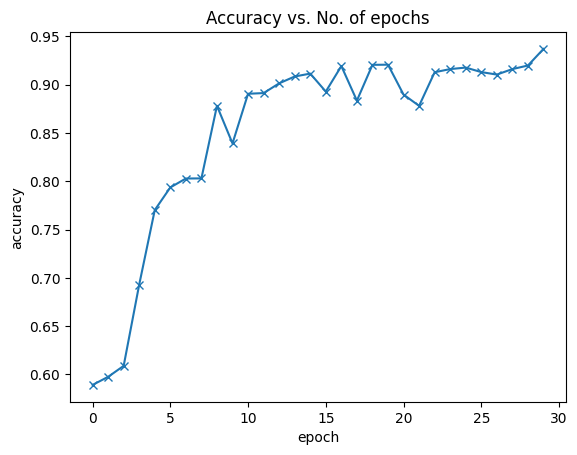

In [ ]:
plot_accuracies(history)

In [ ]:
pip install transformers


In [ ]:
pip install soundfile


In [ ]:
pip install torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
pip install SpeechRecognition


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 16.4 MB/s eta 0:00:00
